<a href="https://colab.research.google.com/github/Luke-687/Chemotaxis-Project-With-RL/blob/main/3_4_Cart_Pole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
!pip install gymnasium pygame numpy matplotlib

In [38]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

In [66]:
#Establish environment
env = gym.make('CartPole-v1', render_mode = None)

#Establish bounds of environemtn
def boundaries():
  bounds = [
      np.linspace(-4.8,4.8,10), #Cart Pos.
      np.linspace(-4,4,10), #cart vel.
      np.linspace(-0.5, 0.5, 10), #Pole ang.
      np.linspace(-4,4,10) #Pole vel. at tip
  ]
  return bounds

def discretize(obs, bins):
    return tuple(int(np.digitize(x, b) - 1) for x, b in zip(obs, bins))

#Begin to set up MDP
actions = env.action_space.n
bins = boundaries()
gamma = 0.99
theta = 0.01

V = defaultdict(float)
policy = {}

def optimize():
  iterations = 0
  for i in range(0,10):
    for j in range(0,10):
      for k in range(0,10):
        for l in range(0,10):
          #d tracks convergence
          d = 0
          state = (i,j,k,l)
          v = V[state]
          max_value = float('-inf')
          bestAct = 0
          for a in range(actions):
            total = 0
            for z in range(5):
              obs = [
                    (bins[0][i] + bins[0][min(i+1, 9)]) / 2,
                    (bins[1][j] + bins[1][min(j+1, 9)]) / 2,
                    (bins[2][k] + bins[2][min(k+1, 9)]) / 2,
                    (bins[3][l] + bins[3][min(l+1, 9)]) / 2
                    ]
              env.reset()
              env.unwrapped.state = np.array(obs)
              obs, reward, terminated, truncated, _ = env.step(a)
              done = terminated or truncated
              disc_obs = discretize(obs, bins)
              total += reward + gamma * V[disc_obs] * (0 if done else 1)
            total/=5
            if total>max_value:
              max_value = total
              bestAct = a
          V[state] = max_value
          policy[state] = bestAct
          d = max(d, abs(v-max_value))
          iterations+=1
    if theta>d:
      break
  return V, policy

In [67]:
V,policy = optimize()

/usr/local/lib/python3.11/dist-packages/gymnasium/utils/passive_env_checker.py:158: UserWarning: WARN: The obs returned by the `step()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")


In [ ]:
for state, value in V.items():
    print(f"State: {state}, Value: {value}")

In [68]:
def run_episode(render=False):
    obs, _ = env.reset()
    total_reward = 0

    for t in range(500):  # max episode length in CartPole
        state = discretize(obs, bins)
        action = policy.get(state, env.action_space.sample())  # fallback to random if unseen
        obs, reward, terminated, truncated, _ = env.step(action)
        total_reward += reward
        if render:
            env.render()
        if terminated or truncated:
            break

    return total_reward

In [69]:
scores = [run_episode(render=False) for _ in range(100)]
print(f"Average Reward over 100 episodes: {np.mean(scores)}")
print(f"Max Reward: {np.max(scores)}")
print(f"Min Reward: {np.min(scores)}")

Average Reward over 100 episodes: 9.28
Max Reward: 11.0
Min Reward: 8.0


In [70]:
#Sim is from chat gpt

import matplotlib.pyplot as plt
import numpy as np
import time
from IPython.display import clear_output

def draw_cartpole(cart_position, pole_angle):
    fig, ax = plt.subplots(figsize=(6, 3))
    ax.set_xlim(-2.5, 2.5)
    ax.set_ylim(-1, 1.5)

    # Draw cart
    cart_width = 0.4
    cart_height = 0.2
    cart = plt.Rectangle((cart_position - cart_width / 2, 0), cart_width, cart_height, fc='black')
    ax.add_patch(cart)

    # Draw pole
    pole_length = 1.0
    pole_x = cart_position + pole_length * np.sin(pole_angle)
    pole_y = cart_height + pole_length * np.cos(pole_angle)
    ax.plot([cart_position, pole_x], [cart_height, pole_y], lw=3, color='blue')

    # Draw ground
    ax.axhline(0, color='gray', lw=2)

    ax.set_title("CartPole Simulation")
    ax.axis('off')
    plt.show()

def run_visual_episode(env, policy, bins, delay=0.05):
    obs, _ = env.reset()
    total_reward = 0
    for _ in range(500):
        clear_output(wait=True)
        cart_pos = obs[0]
        pole_ang = obs[2]
        draw_cartpole(cart_pos, pole_ang)

        state = discretize(obs, bins)
        action = policy.get(state, env.action_space.sample())
        obs, reward, terminated, truncated, _ = env.step(action)
        total_reward += reward
        if terminated or truncated:
            break
        time.sleep(delay)
    print(f"Total reward: {total_reward}")

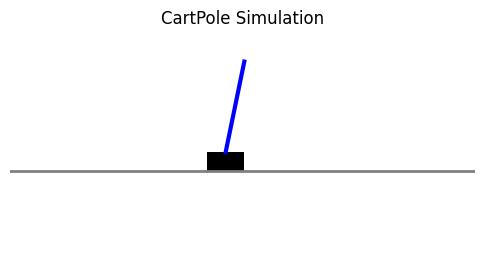

Total reward: 10.0


In [78]:
run_visual_episode(env, policy, bins, delay=0.1)